# CSCI 4253 Final Project
# Machine Learning Prototype

Brief note on the following. We compare a couple of machine learning models to see which one feels better for the situation based on metrics and ease of use. 

Note that as this is not a machine learning course, the level of performance metrics and testing is not deeply intensive, rather simple to quickly determine which model to choose.

We have decided on using: 

In [221]:
import io
import boto3
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

<br><br><br><br>
## Import Data
***
Please change the configuration below for your own local settings. Currently this is importing a CSV file from an AWS S3 bucket.

In [ ]:
s3 = boto3.client('s3')
file = s3.get_object(Bucket = '', Key = '.csv')
df_all = pd.read_csv(io.BytesIO(file['Body'].read()))
print("Done!")

Use the code below for testing with a local csv file:

In [ ]:
df_all = pd.read_csv("music.csv")
print("Done!")

<br><br><br><br>
## Process the data
***
Remove or configure any additional input features below.

The following features are currently being analyzed as input features:
- energy (not available in data set currently but will add it for next checkpoint)
- duration
- beats_start (number of beats in a song)
- loudness
- tempo
- year
- mode
- key

The output feature is:
- song_hotttnesss

For descriptions, please see: https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description.

#### Below is a preview of the dataset

In [15]:
df_all.head()

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


#### This is a preview of the input features (and output) that we are using for our data set. Notice that the amout of data missing a "hotttnesss" score is relatively large. This can impact the final accuracy and an alternative method should be considered.

In [109]:
df = df_all[['duration','beats_start', 'loudness', 'tempo', 'year', 'mode', 'key', 'song.hotttnesss']]
df = df.dropna()
print(df.head())
print("There are", df.shape[0], "data points.")

     duration  beats_start  loudness    tempo  year  mode  key  \
0   218.93179      0.58521   -11.197   92.198     0     0  1.0   
4   209.60608      0.13576    -4.501  129.738  2007     1  2.0   
8   269.81832      1.22595   -13.496   86.643  1984     1  4.0   
10  218.77506      0.11194   -10.021  146.765     0     0  5.0   
11  245.21098      0.42896    -7.545  117.975     0     1  7.0   

    song.hotttnesss  
0          0.602120  
4          0.604501  
8          0.265861  
10         0.000000  
11         0.265861  
There are 5649 data points.


#### While looking at the year, it appears that over many datapoints of the sample do not have a year. This would be too little data - so for now the year will be removed. However, it is still a possibility that we could get the year through another service, or draw more data which has the year available.

In [110]:
# Can also use .sample(x) to get x random data points
print("There are", df[df.year != 0].shape[0],"data points")
print("Done!")

There are 3064 data points
Done!


In [115]:
X_all = df.drop(columns=['song.hotttnesss'])
y_all = df['song.hotttnesss']

<br><br><br><br>
## Split the data
***
Split the data into training and testing. The model will train on the "training" data and then to test the accuracy we check how well the model performed in predicting the testing data.

For now, 80% of the data will be used for training.

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size =0.2, random_state=39)
print("Done!")

Done!


For classification, we want labels, aka "hot" or "not hot" for our predictions. Below converts into binary labels based on a threshold which determines which songs are "hot".

In [180]:
threshold = 0.7
y_train_label = [y >= threshold for y in y_train]
y_test_label  = [y >= threshold for y in y_test]

<br><br><br><br>
## Train the model
***
For our model, since we are predicting a "hotness" score for an input. That is, given a plethora of data about a song, our model will take that and give a score in [0,1] which will represent how popular a song is.

Note we are comparing two different models below.

### K-Nearest-Neighbors (KNN)
Below, we are using k-nearest-neighbors, where we classify a song as popular based on proximity to other datapoints. We can also get a confidence score to based on proximity. For parameter tuning, we can also adjust the number of neighbours. 

Please see: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html for more information about KNN.

In [183]:
from sklearn.neighbors import KNeighborsClassifier

def createKnn(n_neighbors, X, y):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(X,y)
    return knn

In [203]:
# E.g. to create a KNN model:
# knn = createKnn(3, X_train, y_train_label)
# print("Done!")

### Logistic Regression
Below, we are using logistic regression, where we classify a song as popular if its hotness >= x where x is between 0 and 1 (e.g. x = 0.6). This would tell us not only if a song will be popular, but give us a confidence score, similar to hotness. 

Please see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for more information about LogisticRegression.

In [254]:
from sklearn.linear_model import LogisticRegression
def createLogReg(c, X, y):
    logReg = LogisticRegression(penalty = "l2", C=c)
    logReg.fit(X, y)
    return logReg

In [255]:
# E.g. to create a Logistic Regression model:
# logReg = createLogReg(X_train, y_train_logReg)
# print("Done!")

### Note on Linear Regression
We tried using multivariate linear regression but for now decided to stick with classification. This is for a couple of reasons. Ultimately, we wanted to predict if a song is "hot" or "not hot" which is binary classification. Classification seemed more appropriate here, where we can then assign a confidence score afterwards (logisitc regression does the same principle of regression, but with a confidence score and binary classification). Secondly, we wanted to make it easier to compare metrics and felt for now it would be most feasible to only use classification to assist in comparison.

For more information on Linear Regression in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

<br><br><br><br>
## Testing
***

### K-Nearest-Neighbors (KNN)

To tune KNN, we will adjust the number of neighbors and see how the performance is affected (analyzed in the metrics section below).

In [256]:
knn_accuracies_test = []
knn_accuracies_train = []
n_neighbors = range(1,15,2)
for n in n_neighbors:
    print("Testing N =",n)
    knn = createKnn(n, X_train, y_train_label)
    y_predict_knn = knn.predict(X_test)
    knn_accuracies_test.append(accuracy_score(y_predict_knn, y_test_label))
    knn_accuracies_train.append(accuracy_score(knn.predict(X_train), y_train_label))
    
print("Average Accuracy ~", knn_accuracy)

Testing N = 1
Testing N = 3
Testing N = 5
Testing N = 7
Testing N = 9
Testing N = 11
Testing N = 13
Average Accuracy ~ 0.9212389380530973


### Logistic Regression

To tune Logistic Regression, we adjust the regularization strength. This affects how large the coefficients become for each input. This means these values affects the bias-variance tradeoff for how much a model either overfits or or overgeneralizes based on the data.

In [257]:
logReg_accuracies_test = []
logReg_accuracies_train = []
C_values = np.append(np.append(np.array([0.1]),np.arange(1,10,1)),np.arange(10,50,10))
for c in C_values:
    print("Testing C =",c)
    logReg = createLogReg(c, X_train, y_train_label)
    y_predict_logReg = logReg.predict(X_test)
    logReg_accuracies_test.append(accuracy_score(y_predict_logReg, y_test_label))
    logReg_accuracies_train.append(accuracy_score(logReg.predict(X_train), y_train_label))
    
print("Average Accuracy ~", logReg_accuracy)

Testing C = 0.1
Testing C = 1.0
Testing C = 2.0
Testing C = 3.0
Testing C = 4.0
Testing C = 5.0
Testing C = 6.0
Testing C = 7.0
Testing C = 8.0
Testing C = 9.0
Testing C = 10.0
Testing C = 20.0
Testing C = 30.0
Testing C = 40.0
Average Accuracy ~ 0.9362831858407079


<br><br><br><br>
## Metrics
***
Below are graphs comparing accuracies for testing and training. Training data is analyzed to check for over-fitting.

### K-Nearest-Neighbors (KNN)

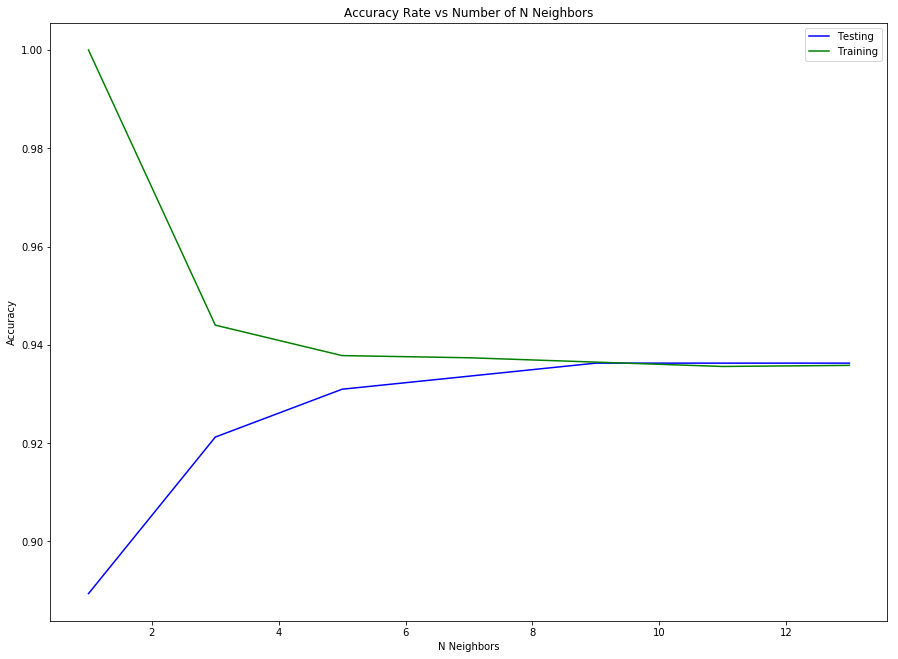

In [258]:
plt.figure(figsize = (15,11))
plt.xlabel("N Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy Rate vs Number of N Neighbors")
plt.plot(n_neighbors, knn_accuracies_test, color = "blue")
plt.plot(n_neighbors, knn_accuracies_train, color = "green")
plt.legend(["Testing", "Training"])
plt.show()

### Logistic Regression

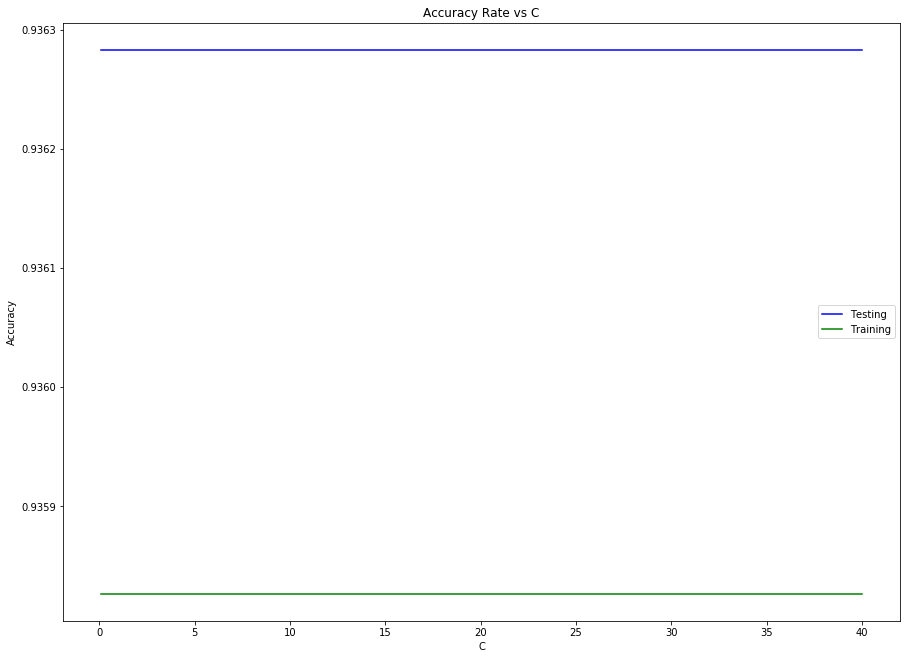

In [259]:
plt.figure(figsize = (15,11))
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy Rate vs C")
plt.plot(C_values, logReg_accuracies_test, color = "blue")
plt.plot(C_values, logReg_accuracies_train, color = "green")
plt.legend(["Testing", "Training"])
plt.show()

## Conclusion
***